# Sentiment Analysis of IMDB Review

## Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import re

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## Importing imdb dataset

In [4]:
# Reading the imdb dataset as csv file
imdb = pd.read_csv('https://raw.githubusercontent.com/Ankit152/IMDB-sentiment-analysis/master/IMDB-Dataset.csv')

## View the first five sample of the dataset

In [5]:
# View the first five sample of the dataset
# Dataset contains 2 features (review and sentiment)
# Review is our input feature
# sentiment is the target feature
imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
# making a duplicate copy of the original dataset
# We will work on duplicate copy while refraining ourself from making changes on original dataset
imdb_df = imdb.copy()

## Data Preprocessing

### Checking if the dataset contains Null values

In [7]:
imdb_df.isnull().sum()

review       0
sentiment    0
dtype: int64

### Checking for the duplicates entries in the dataset

In [8]:
imdb_df.duplicated().sum()

418

### Removing the duplicates entries from dataset

In [9]:
imdb_df.drop_duplicates(inplace =True)

### Checking the whether the dataset is balanced or imbalanced

In [10]:
imdb_df.sentiment.value_counts()

positive    24884
negative    24698
Name: sentiment, dtype: int64

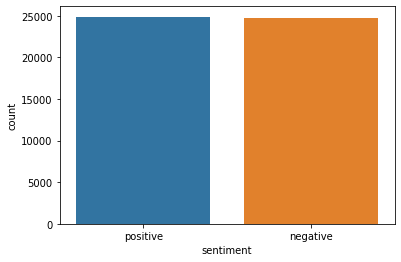

In [11]:
sns.countplot(x= imdb_df['sentiment'])
plt.show()

## Text Preprocessing


In [12]:
stop_word = stopwords.words('english')
stop_word = stop_word[:116]

### Lowercasing

In [13]:
imdb_df['review'] = imdb_df['review'].str.lower()

### Removing HTML tags

In [14]:
def remove_html_tags(doc):
  return re.sub('<.*?>', '', doc)

In [15]:
imdb_df['review'] = imdb_df['review'].apply(lambda x:remove_html_tags(x))

### Remove URLs

In [16]:
def remove_urls(doc):
  return re.sub(r'https?://\S+|www\.\S+', '', doc)

In [17]:
imdb_df['review'] = imdb_df['review'].apply(lambda x:remove_urls(x))

### Remove stopwords

In [18]:
def remove_stopwords(doc):
  return ' '.join([word for word in word_tokenize(doc) if not word in stop_word])

In [19]:
imdb_df['review'] = imdb_df['review'].apply(lambda x:remove_stopwords(x))

### Remove unnecessary characters

In [20]:
def remove_characters(doc):
  text = re.sub('[^a-zA-Z]', ' ', doc)
  return re.sub('\s+', ' ', text)

In [21]:
imdb_df['review'] = imdb_df['review'].apply(lambda x:remove_characters(x))

### Applying Lemmatization

In [22]:
lemmatizer = WordNetLemmatizer()

In [23]:
def apply_lemmatization(doc):
  return ' '.join([lemmatizer.lemmatize(word, 'v') for word in word_tokenize(doc)])

In [24]:
imdb_df['review']= imdb_df['review'].apply(lambda x:apply_lemmatization(x))

In [25]:
imdb_df.head()

,review,sentiment
0,one reviewers mention watch just oz episode ll...,positive
1,wonderful little production film technique ver...,positive
2,think wonderful way spend time too hot summer ...,positive
3,basically s family little boy jake think s zom...,negative
4,petter mattei s love time money visually stun ...,positive


### Creating input features

In [26]:
X = imdb_df['review']

### Creating our target variable

In [27]:
y = pd.get_dummies(imdb_df['sentiment'], drop_first= True)

In [28]:
 y = y['positive']

In [29]:
y

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: positive, Length: 49582, dtype: uint8

### Splitting our dataset into train set and test set

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 40)

In [32]:
X_train.shape

(37186,)

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

### Creating tokenizer

In [34]:
def word_tokens(doc):
  return word_tokenize(doc)

## Modelling

### Using Bag of Words Model for Training

In [35]:
bow = CountVectorizer(binary= True, ngram_range=(1,2), max_df = 9000, tokenizer=word_tokens)

In [36]:
X_train = bow.fit_transform(X_train)
X_test = bow.transform(X_test)

In [37]:
X_train.shape

(37186, 2252740)

#### Using Multinomial Naive bayes to train our bag of word model

In [38]:
from sklearn.naive_bayes import MultinomialNB

In [39]:
nb_model = MultinomialNB()

##### Fitting our Training set

In [40]:
nb_model.fit(X_train, y_train)

MultinomialNB()

##### Predicting our target outputs

In [41]:
y_pred = nb_model.predict(X_test)

In [42]:
from sklearn.metrics import confusion_matrix, classification_report

##### Evaluating our model using confusion matrix

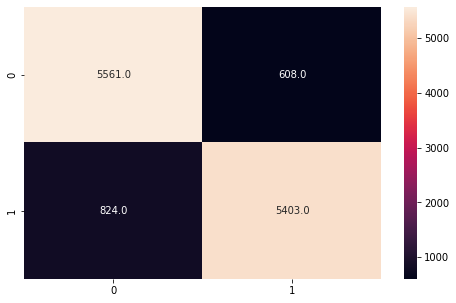

In [43]:
plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.1f')
plt.show()

##### Evaluating our model using classification report

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89      6169
           1       0.90      0.87      0.88      6227

    accuracy                           0.88     12396
   macro avg       0.88      0.88      0.88     12396
weighted avg       0.88      0.88      0.88     12396



In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
rf_model = RandomForestClassifier()

In [47]:
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [48]:
rf_y_pred = rf_model.predict(X_test)

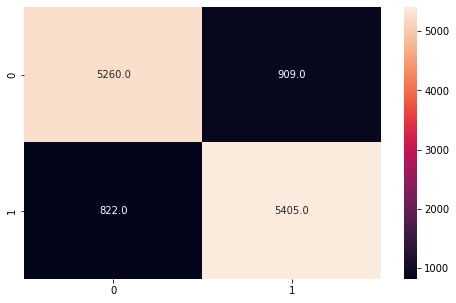

In [49]:
plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, rf_y_pred), annot=True, fmt='.1f')
plt.show()

In [50]:
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      6169
           1       0.86      0.87      0.86      6227

    accuracy                           0.86     12396
   macro avg       0.86      0.86      0.86     12396
weighted avg       0.86      0.86      0.86     12396



In [51]:
from sklearn.linear_model import LogisticRegression

In [52]:
lr_model = LogisticRegression(max_iter=500)

In [53]:
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [54]:
lr_y_pred = lr_model.predict(X_test)

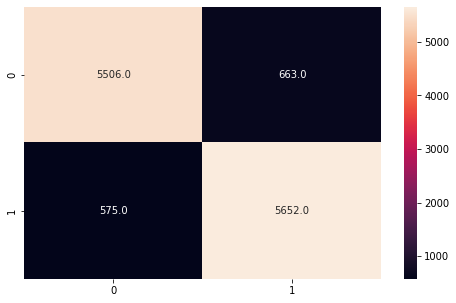

In [55]:
plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, lr_y_pred), annot=True, fmt='.1f')
plt.show()

In [56]:
print(classification_report(y_test, lr_y_pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      6169
           1       0.90      0.91      0.90      6227

    accuracy                           0.90     12396
   macro avg       0.90      0.90      0.90     12396
weighted avg       0.90      0.90      0.90     12396



### Using TF-IDF for Training

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [60]:
tf_idf = TfidfVectorizer(ngram_range=(1,2), tokenizer= word_tokens, max_features=9000, min_df=3)

In [61]:
tf_X_train = tf_idf.fit_transform(X_train)
tf_X_test = tf_idf.transform(X_test)

In [62]:
mnb_model = MultinomialNB()

In [64]:
mnb_model.fit(tf_X_train, y_train)

MultinomialNB()

In [66]:
tf_y_pred = mnb_model.predict(tf_X_test)

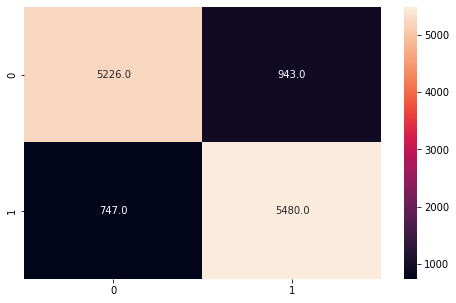

In [67]:
plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, tf_y_pred), annot=True, fmt='.1f')
plt.show()

In [68]:
print(classification_report(y_test, tf_y_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      6169
           1       0.85      0.88      0.87      6227

    accuracy                           0.86     12396
   macro avg       0.86      0.86      0.86     12396
weighted avg       0.86      0.86      0.86     12396



In [72]:
rf_tree_model = RandomForestClassifier()

In [73]:
rf_tree_model.fit(tf_X_train, y_train)

RandomForestClassifier()

In [74]:
rft_y_pred = rf_tree_model.predict(tf_X_test )

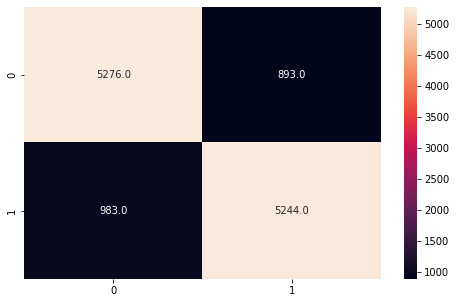

In [75]:
plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, rft_y_pred), annot=True, fmt='.1f')
plt.show()

In [76]:
print(classification_report(y_test, rft_y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      6169
           1       0.85      0.84      0.85      6227

    accuracy                           0.85     12396
   macro avg       0.85      0.85      0.85     12396
weighted avg       0.85      0.85      0.85     12396



In [78]:
lgr_model = LogisticRegression()

In [82]:
lgr_model.fit(tf_X_train, y_train)

LogisticRegression()

In [84]:
lgr_y_pred = lgr_model.predict(tf_X_test)

In [85]:
print(classification_report(y_test, lgr_y_pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      6169
           1       0.89      0.90      0.90      6227

    accuracy                           0.89     12396
   macro avg       0.89      0.89      0.89     12396
weighted avg       0.89      0.89      0.89     12396



### Using Word2Vec Model for Training

In [4]:
!pip install --upgrade numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 46.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.1 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.1 which is incompatible.


In [5]:
import gensim

ValueError: ignored

In [1]:
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 KB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for fst-pso: filename=fst_pso-1.8.1-py3-none-any.whl size=20443 sha256=7bb51fa45acdb344ba1ea0ea4ee886666e60615be8957e6bb9d1ea6cbe59b1d4
  Stored in directory: /root/.cache/pip/wheels/6a/65/c4/d27eeee9ba3fc150a0dae150519591103b9e0dbffde3ae77dc
  Created wheel for miniful: filename=miniful-0.0.6-py3-none-any.whl size=3530 sha256=fdda84ab13d3d2de26f60639b822367416c08acc3d163c65c58ef8d9c185d5da
  Stored in directory: /root/.cache/pip/wheels/ba/d9/a0/ddd93af16d5855dd9bad417623e70948fdac119d1d34fb17c8
Successfully built fst-pso miniful
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0

In [33]:
import gensim
from gensim.models import Word2Vec, KeyedVectors
from gensim.utils import simple_preprocess

#### Applying preprocessing on the data using simple preprocess



In [34]:
story = []
for doc in imdb_df['review']:
  raw_sent = sent_tokenize(doc)
  for sent in raw_sent:
    story.append(simple_preprocess(sent))

In [35]:
gensim_model = Word2Vec(window=10, min_count=2)

#### Building a Vocabulary using word2vec

In [36]:
gensim_model.build_vocab(story)

#### Training the gensim model on the dataset

In [37]:
gensim_model.train(story, total_examples=gensim_model.corpus_count, epochs=gensim_model.epochs)

(29084889, 31406075)

In [38]:
len(gensim_model.wv.index2entity)

51371

In [39]:
len(gensim_model.wv.index2word)

51371

#### Applying Average Word2vec

In [60]:
def document_vector(doc):
  # Removing out of vocabulary words
  doc = [word for word in doc.split() if word in gensim_model.wv.index_to_key]
  return np.mean(gensim_model.wv[doc])

In [61]:
document_vector(imdb_df['review'].values[0])

AttributeError: ignored

In [2]:
gensim.__version__

NameError: ignored

In [55]:
imdb_df['review'].values

array(['one reviewers mention watch just oz episode ll hook right exactly happen me the first thing strike oz brutality unflinching scenes violence set right word go trust not show faint hearted timid show pull no punch regard drug sex violence hardcore classic use word it call oz nickname give oswald maximum security state penitentary focus mainly emerald city experimental section prison cells glass front face inwards so privacy not high agenda em city home many aryans muslims gangstas latinos christians italians irish so scuffle death star dodgy deal shady agreements never far away i would say main appeal show due fact go show would n t dare forget pretty picture paint mainstream audiences forget charm forget romance oz n t mess around first episode ever saw strike so nasty surreal could n t say ready watch develop taste oz get accustom high level graphic violence not just violence injustice crook guard ll sell nickel inmates ll kill order get away well mannered middle class inmates 